In [1]:
mu1 = 2
variance1 = 0.5
mu2 = 10
variance2 = 1

Formula:
![img](s.png)

In [2]:
import numpy as np
def updatePosterior():
    global variance3, mu3, S
    variance3 = 1/(1/variance1 + 1/variance2)
    mu3 = (mu1/variance1 + mu2/variance2)*variance3
    S = 1/(np.sqrt(2*np.pi*variance1*variance2/variance3)) * np.exp(-0.5 * (mu1 - mu2)**2 * variance3/(variance1*variance2))
updatePosterior()
print("Scale factor 1/S is", 1/S)

Scale factor 1/S is 5650469186.93


Note that the scale factor is very large when the two gaussians are far apart

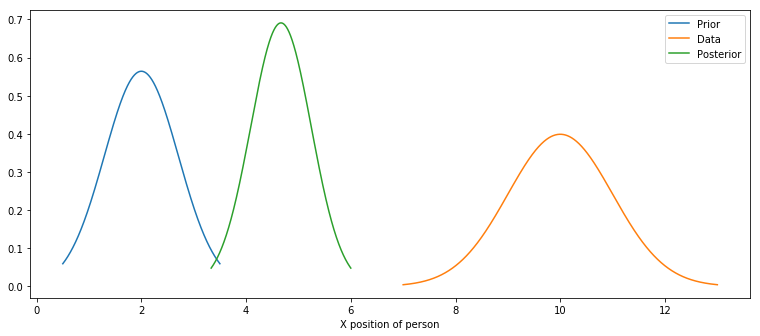

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import math

def plotGaussian(mu, variance, label, interval=3):
    sigma = math.sqrt(variance)
    x = np.linspace(mu-interval*variance,mu+interval*variance, 2000)
    plt.plot(x,mlab.normpdf(x, mu, sigma), label=label)

def plotPriorDataPosterior():    
    plt.figure(figsize=[10,4])
    plt.gca().set_position([0, 0, 1, 1])
    plt.xlabel("X position of person")
    plotGaussian(mu1,variance1, label="Prior")
    plotGaussian(mu2,variance2, label="Data")
    plotGaussian(mu3,variance3, label="Posterior", interval=4)

plotPriorDataPosterior()
plt.legend()

plt.savefig("test.svg", format="svg")
plt.show()

In [4]:
Wprior = 0.01 # 1% chance our prior is wrong
Wdata = 0.01 # 1% chance our data is wrong

def updateMixtureModelWeights():
    global weights
    C = (1-Wprior) * (1-Wdata) * S + (1-Wprior) * Wdata + Wprior * (1-Wdata)

    weights = [
        Wprior * (1-Wdata) /C, # weight of prior
        (1-Wprior) * Wdata /C, # weight of data
        (1-Wprior) * (1-Wdata) * S/C ] #weight of posterior
updateMixtureModelWeights()
weights

[0.49999999561983283, 0.49999999561983283, 8.7603343950323861e-09]

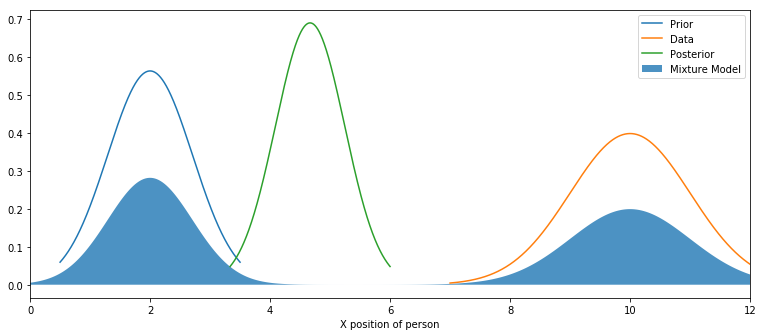

In [5]:
def plotGaussianMixtureModel(mus, variances, weights, startX, endX, interval=3):
    x = np.linspace(startX,endX, 2000)
    y = np.zeros_like(x)
    for mu,variance,weight in zip(mus, variances, weights):
        sigma = math.sqrt(variance)
        y += mlab.normpdf(x, mu, sigma)*weight
    #plt.plot(x,y, label="Mixture Model")
    plt.gca().fill_between(x, 0, y, label="Mixture Model", alpha=0.8)

def doMixtureModel(filename=None):
    updatePosterior()
    updateMixtureModelWeights()
    startX = 0
    endX = 12
    plotPriorDataPosterior()
    plotGaussianMixtureModel([mu1, mu2, mu3], [variance1, variance2, variance3], weights, startX, endX)
    plt.gca().set_xlim([0,12])
    plt.legend()
    if filename:
        plt.savefig(filename, dpi=200)
        plt.close()
    else:
        plt.show()

mu1 = 2
variance1 = 0.5
mu2 = 10
variance2 = 1
doMixtureModel()

In [6]:
for i in np.arange(2,6,0.1):
    mu1 = i
    variance1 = 0.5
    mu2 = 12-i
    variance2 = 1
    doMixtureModel('anim_%03d.png' % (i*10))
#converted to a gif with:
# convert anim_*.png -coalesce   -duplicate 1,-2-1 -quiet -layers OptimizePlus  -loop 0   anim.gif

![img](anim.gif)

In [7]:
def updateMixtureModelApproximationWeights():
    global mu4, variance4
    mu4 = weights[0]*mu1 + weights[1]*mu2 + weights[2] * mu3
    variance4 = weights[0]*(variance1 + (mu1 - mu4)**2) + \
                weights[1]*(variance2 + (mu2 - mu4)**2) + \
                weights[2]*(variance3 + (mu3 - mu4)**2)
updateMixtureModelApproximationWeights()
variance4

0.3586262877842164

In [8]:
def doMixtureModelWithApproximation(filename=None):
    updatePosterior()
    updateMixtureModelWeights()
    updateMixtureModelApproximationWeights()
    startX = 0
    endX = 12
    plotPriorDataPosterior()
    plotGaussianMixtureModel([mu1, mu2, mu3], [variance1, variance2, variance3], weights, startX, endX)
    plotGaussian(mu4,variance4, label="Mixture Model Approximated")
    plt.gca().set_xlim([0,12])
    plt.legend()
    if filename:
        plt.savefig(filename, dpi=200)
        plt.close()
    else:
        plt.show()
    
for i in np.arange(2,6,0.1):
    mu1 = i
    variance1 = 0.5
    variance2 = 1
    mu2 = (6 * (1/variance1 + 1/variance2) - mu1/variance1) * variance2
    doMixtureModelWithApproximation('animapprox_%03d.png' % (i*10))
#converted to a gif with:
# convert animapprox_*.png -coalesce   -duplicate 1,-2-1 -quiet -layers OptimizePlus  -loop 0   animapprox.gif

![img](animapprox.gif)

# Summary

When we have some current guess at the position of a person (for example), as shown by the prior in blue, and we gather some new data about their position via LIDAR (for example), sometimes something goes wrong and the two do not agree.

By adding in a small 1% chance of a 'wtf' factor, we get a much more realistic result for the posterior as shown by the red line, compared to the usual estimation as shown by the green line.